Ch6. Using a nueral network to fit the data
-------------------------------------------

>- 직접 구현하던 신경망의 학습을 파이토치를 이용해서 간단하게 구현
>- 활성함수의 개념

신경망의 기본 구조는 **뉴런**으로 이루어진 다중 **계층**이다.
뉴런은 입력에 대해 선형변환을 한 뒤 **활성 함수**(**Activation function**)라는 비선형 함수를 적용한다.

이를 일반적인 수식으로 나타내면 $o =f(w * x + b)$으로 나타낼 수 있다. 각 변수가 스칼라 값이 아닌 벡터 값이면 여러 차원으로 가중치와 편향 값을 가진 여러 개의 뉴런으로 나타낸다. 이를 뉴런 **계층**이라고 한다. 이 계층을 여러 개 쌓아 만든 것이 신경망이다.

![image.png](assets/image.png)


각 뉴런의 파라미터 값을 역전파(backward)를 통해 조정한다. 이를 통해 손실 함수의 값을 낮추는 것이 최종 목표이다.


In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

랜덤으로 train과 valid를 나누기 때문에 초기 가중치와 편향치가 책과 다를 수 있다.

In [2]:
import torch.nn as nn

linear_model = nn.Linear(1,1) # num of input feature, num of output feature, bias(defualt = True)
linear_model(t_un_val)

tensor([[-4.5753],
        [-6.2456]], grad_fn=<AddmmBackward0>)

아래 두 줄은 결과적으로 같은 output이지만 `model`에 인자값을 넣고 호출하는 게 안전하다. `nn/modules/module.py`를 보면 `forward`를 진행하기 전에 수많은 `hook`을 진행한다.

In [4]:
y = model(x) # 권장
# y = model.forward(x)

NameError: name 'model' is not defined

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.7769]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.1171], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.6598], grad_fn=<AddBackward0>)

위 코드에서 `linear_model`은 원하는 값을 뱉었다. 하지만 파이토치의 `nn.Module`은 다양한 샘플을 받기 위해  0번째 차원에 배치(batch)의 수가 들어있는걸 전제로 한다. $B \times Nin$ 크기의 텐서를 넣어보자. $B$는 배치의 사이즈를 나타내고 $Nin$은 input feature의 수를 나타낸다.

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.6598],
        [-0.6598],
        [-0.6598],
        [-0.6598],
        [-0.6598],
        [-0.6598],
        [-0.6598],
        [-0.6598],
        [-0.6598],
        [-0.6598]], grad_fn=<AddmmBackward0>)

입력한 데이터의 배치 수와 동일한 결과의 수가 나왔다.

> 배치를 사용하는 이유
> - 연산 자원을 최대한 활용하기 위해
> - (특정 모델의 경우) 전체 배치의 통계적 정보를 이용하기 때문. 배치의 사이즈가 클수록 더 좋은 결과를 얻는다.

기존 온도 예제 데이터는 단순한 1차원 형태의 데이터였다. 이를 배치 형태($B \times Nin$)로 바꾸기 위해 `unsqeeze`를 사용한다.

In [10]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [11]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(
    linear_model.parameters(), # 기존 params 자리
    lr = 1e-2
)

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.9079]], requires_grad=True),
 Parameter containing:
 tensor([0.3282], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train.to(torch.float32), t_c_train.to(torch.float32))

        # 왜 valid 셋에 nograd 안하지?
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val.to(torch.float32), t_c_val.to(torch.float32))

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [14]:
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_val=t_c_val,
    t_c_train=t_c_train,
)
print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 224.4041, Validation loss 781.0714
Epoch 1000, Training loss 4.0795, Validation loss 9.0384
Epoch 2000, Training loss 2.9131, Validation loss 4.1889
Epoch 3000, Training loss 2.8526, Validation loss 3.6025

Parameter containing:
tensor([[5.2152]], requires_grad=True)
Parameter containing:
tensor([-16.4789], requires_grad=True)


이전 챕터에서 한 훈련 방식을 파이토치의 모듈로 간단하게 표현하고 진행했다. 하지만 신경망은 위의 과정에서 **활성 함수**(**Activation Function**)**가 더 필요하다. 지금부터는 선형 함수 모델에 **활성 함수**(**Activation Function**)**를 씌워 간단한 신경망을 만들어보도록 한다.

지금부터 만들 신경망의 아키텍처는 아래 그림과 같다. 기본적으로 신경망은 선형 모듈에 활성 함수를 씌운 층(layer, module)을 거친 값을 다음 선형 모듈에 넣는 방식이다.

![](.notepad_images/241f3591.png)


In [15]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [16]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

`named_paramters` 메소드를 이용하면 여러 층으로 이루어진 모델의 파라미터를 추적하기 더 쉽다.

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [18]:
from _collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]
)
)
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

위 결과를 알아보기 쉽게 바꾸면 아래와 같다.

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


특정 `parameter`에 접근할 수 있다.

In [20]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1671], requires_grad=True)

In [21]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val,
)

print('output', seq_model(t_u_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 144.0058, Validation loss 529.1395
Epoch 1000, Training loss 4.6777, Validation loss 44.3086
Epoch 2000, Training loss 2.9495, Validation loss 24.0002
Epoch 3000, Training loss 2.3372, Validation loss 15.8180
Epoch 4000, Training loss 2.0214, Validation loss 11.4119
Epoch 5000, Training loss 1.7929, Validation loss 8.7221
output tensor([[27.0311],
        [27.0311]], grad_fn=<AddmmBackward0>)
answer tensor([[13.],
        [28.]])
hidden tensor([[-0.0185],
        [ 0.0320],
        [-0.1293],
        [-0.0253],
        [-0.0223],
        [-0.0511],
        [-0.0214],
        [-0.0575]])


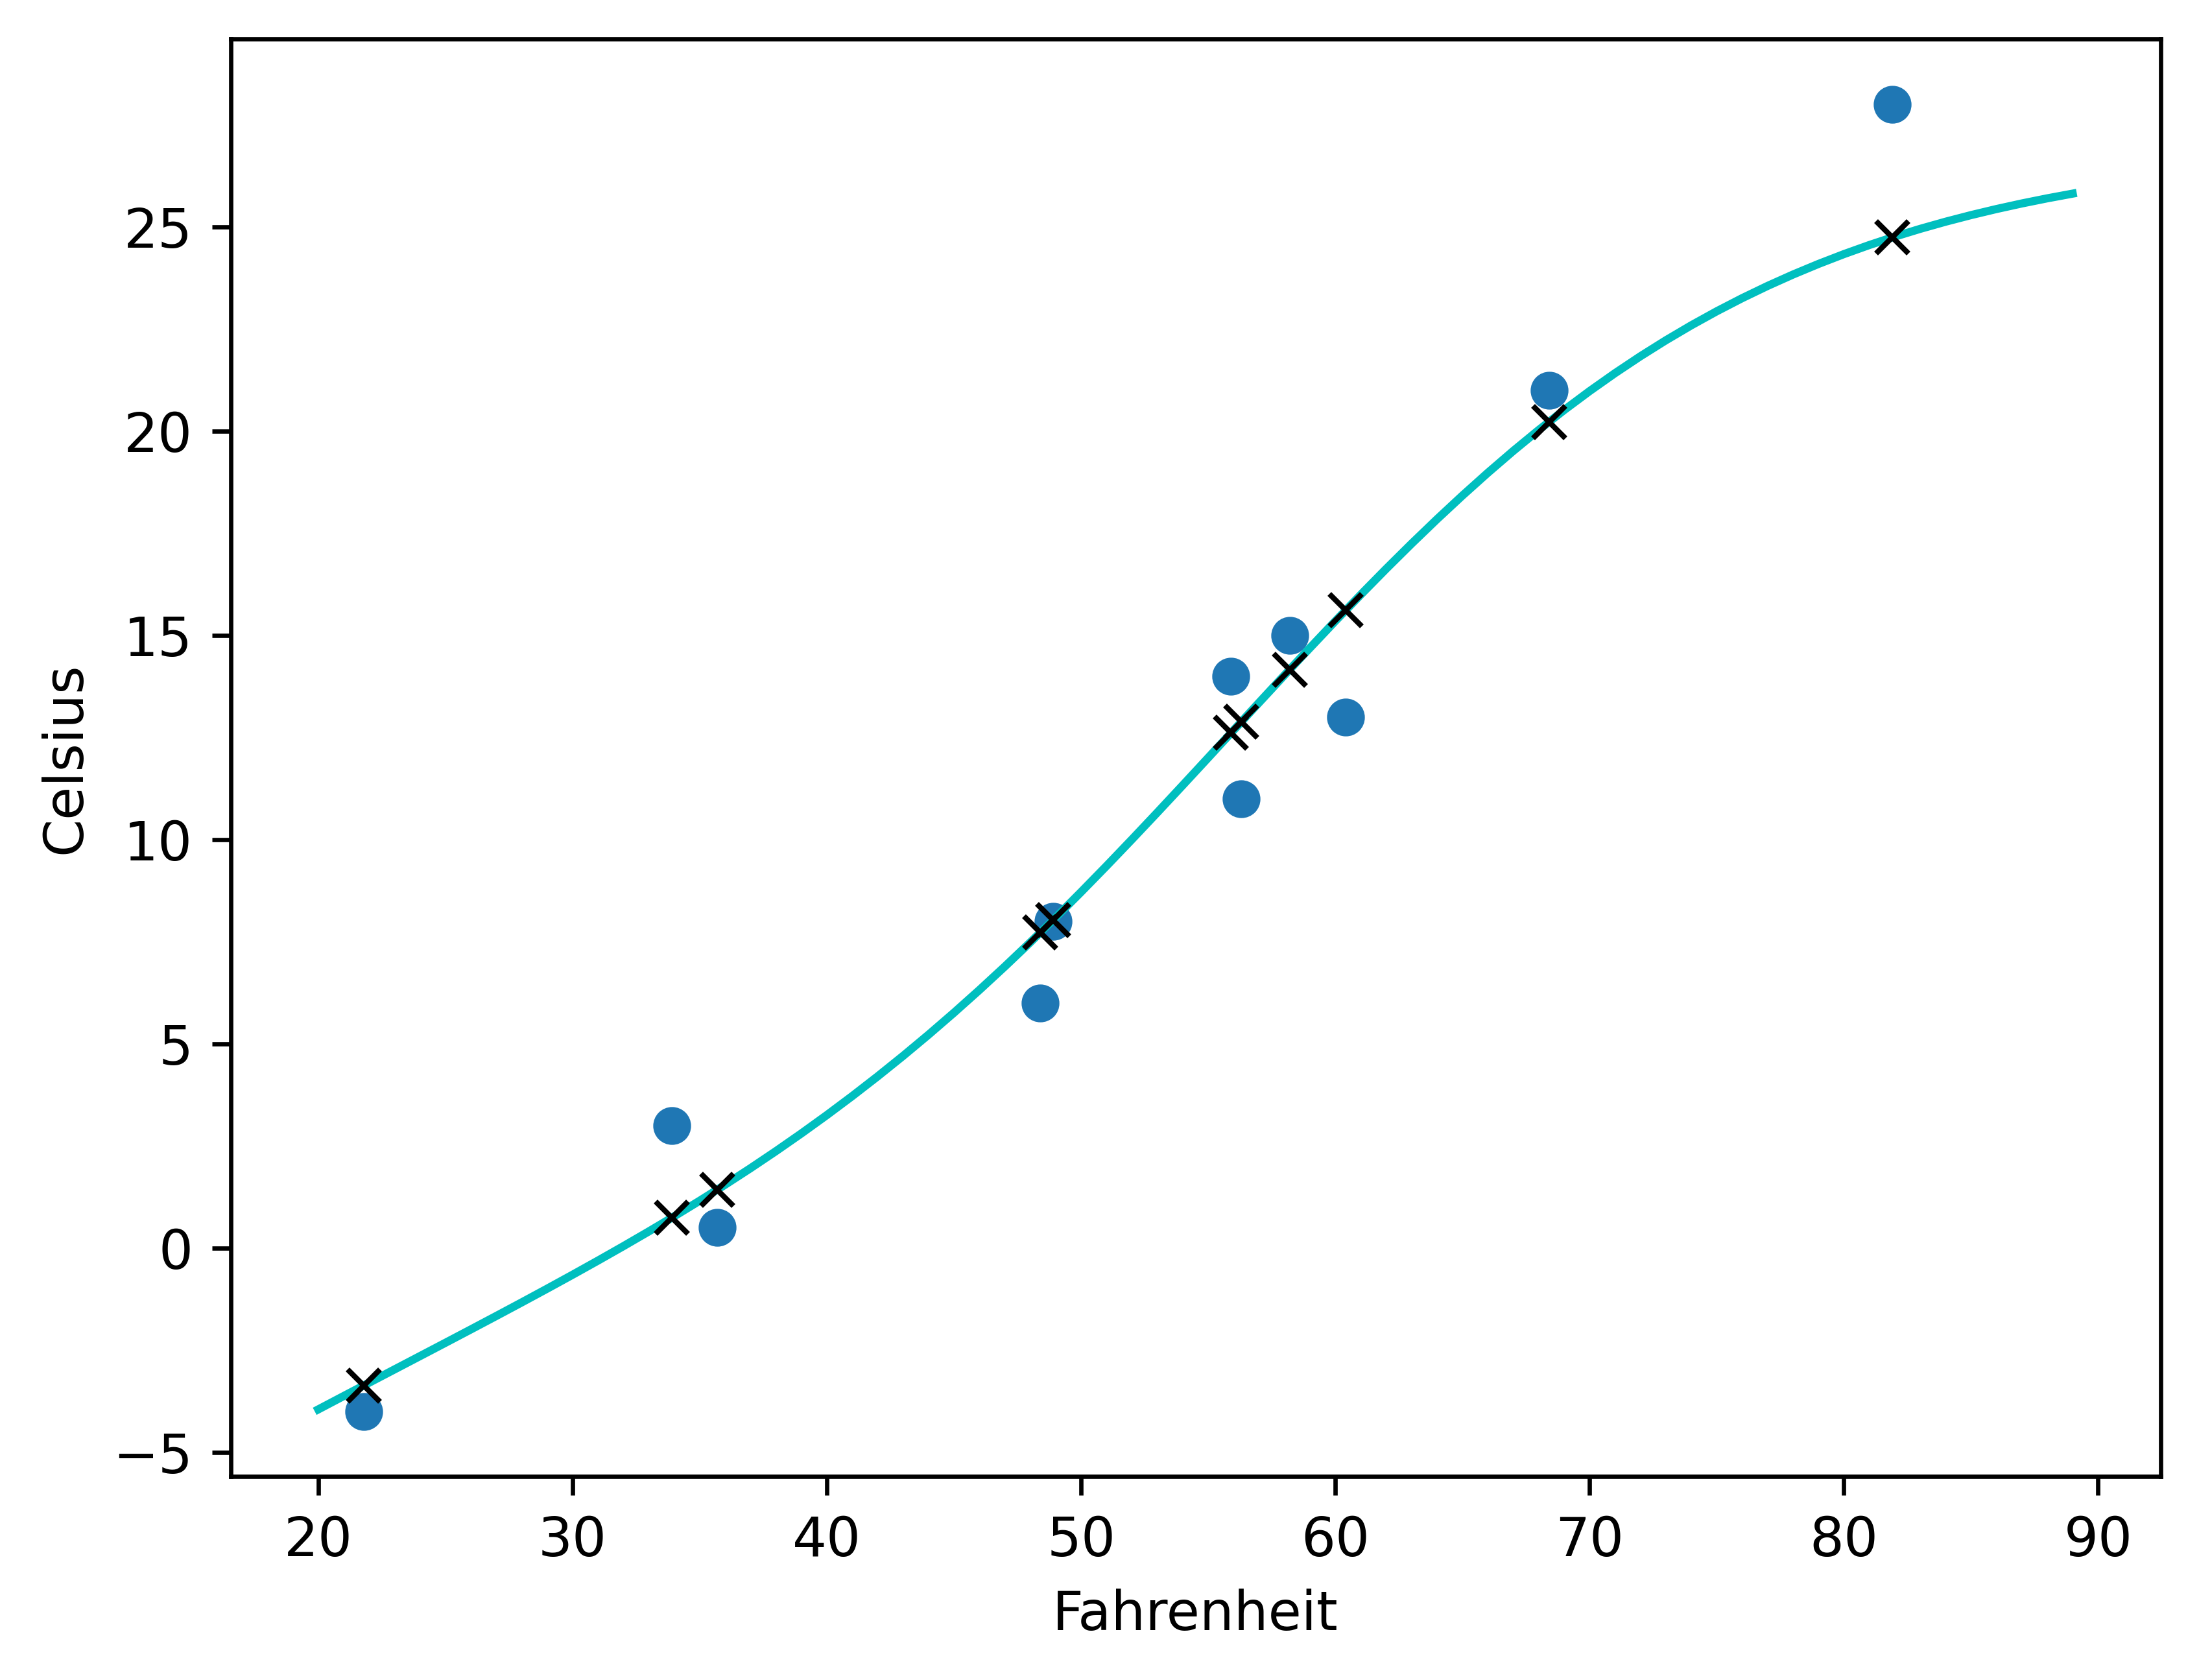

In [22]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

## 연습 문제
---
1. 간단한 신경망 모델에서 여러 은닉층 뉴런과 학습률로 실험해보라
- 어떤 값을 바꿀 때 모델의 출력이 더욱 선형이 되었나?
    - *각 층의 아웃풋 차원 수를 늘릴 때* (계층 수를 늘릴 때 더 심하게 과적합이 된다.)
- 확실하게 과적합하는 모델을 만들 수 있는가?
    - *학습률과 인풋, 아웃풋을 같이 조정한 결과 선형에 가까워졌다.*(계층 수를 늘릴 때 더 심하게 과적합이 된다.)


In [23]:
from _collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 100)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(100,1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=6000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val,
)

Epoch 1, Training loss 132.5006, Validation loss 497.7475
Epoch 1000, Training loss 3.2456, Validation loss 12.9939
Epoch 2000, Training loss 2.7525, Validation loss 7.1018
Epoch 3000, Training loss 2.5206, Validation loss 4.9839
Epoch 4000, Training loss 2.3634, Validation loss 3.8868
Epoch 5000, Training loss 2.2426, Validation loss 3.2586
Epoch 6000, Training loss 2.1455, Validation loss 2.9051


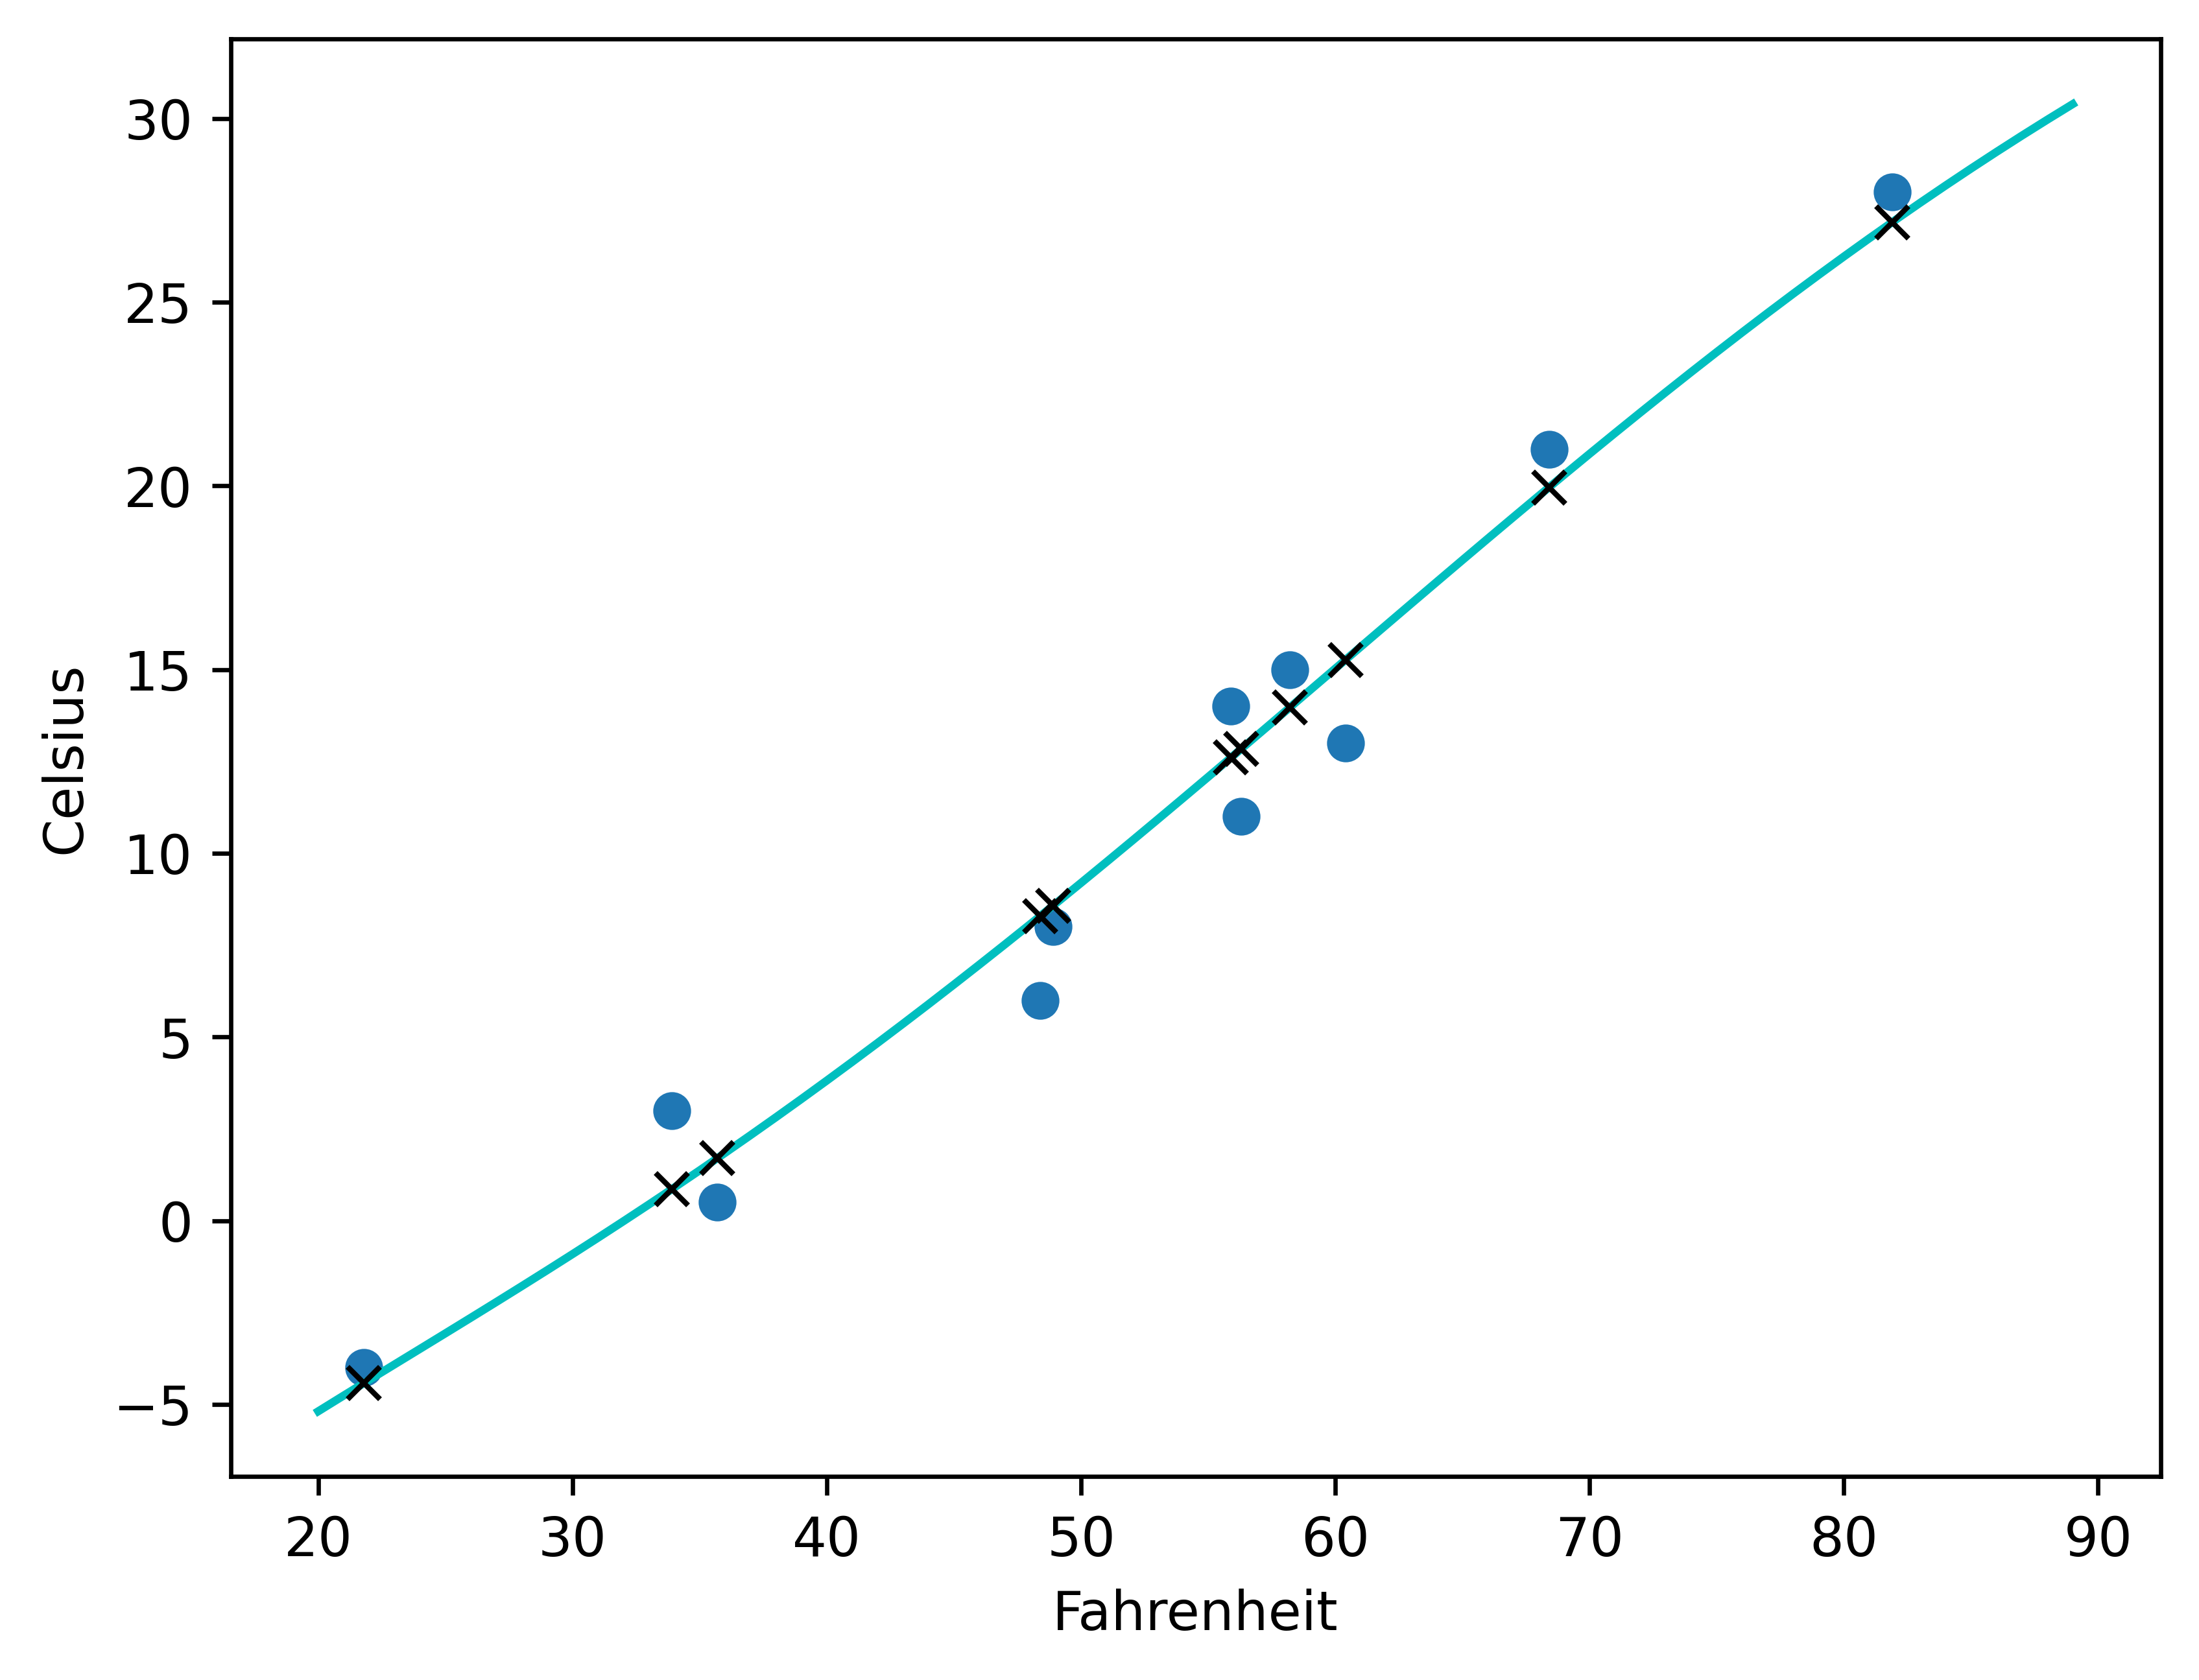

In [24]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

2. 4장의 와인 데이터를 읽어서 적당한 수의 입력 파라미터를 가지는 모델을 만들어라.
    *data.dtype을 float32로 변경*
- 앞에서 다룬 온도 데이터와 비교할 때 훈련 시간이 얼마나 더 오래 걸리는가?
    - *훨씬 오래 걸린다.*
- 어떤 요소가 훈련 시간에 영향을 주는지 설명할 수 있는가?
    - *각 층의 아웃풋 차원의 수*
- 데이터셋으로 훈련시키는 동안 손실이 줄어들었는가?
    - *줄어들었다.*
- 데이터셋을 어떻게 그래프로 표현할 것인가?

In [25]:
import csv
wine_path = "data/p1ch4/tabular-wine/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",skiprows=1)

In [26]:
wineq = torch.from_numpy(wineq_numpy)


data = wineq[:, :-1] # <1>
target = wineq[:, -1]# <2>
target_unsqueezed = target.unsqueeze(1)
data_mean = torch.mean(data, dim=0)
data_var = torch.var(data, dim=0)
data_normalized = (data - data_mean) / torch.sqrt(data_var)

In [27]:
# data split
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

data_train = data[train_indices]
target_train = target[train_indices]

data_val = data[val_indices]
target_val = target[val_indices]

In [28]:
seq_model2 = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(11, 30)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(30,1))
]))

optimizer = optim.SGD(seq_model2.parameters(), lr=1e-3)

training_loop(
    n_epochs=1000,
    optimizer=optimizer,
    model=seq_model2,
    loss_fn=nn.MSELoss(),
    t_u_train=data_train,
    t_u_val=data_val,
    t_c_train=target_train,
    t_c_val=target_val,
)

C:\Users\soso6\miniconda3\envs\Deeplearning with PyTorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([3919])) that is different to the input size (torch.Size([3919, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\soso6\miniconda3\envs\Deeplearning with PyTorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([979])) that is different to the input size (torch.Size([979, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Training loss 20.5102, Validation loss 20.5295
Epoch 1000, Training loss 0.7891, Validation loss 0.7952


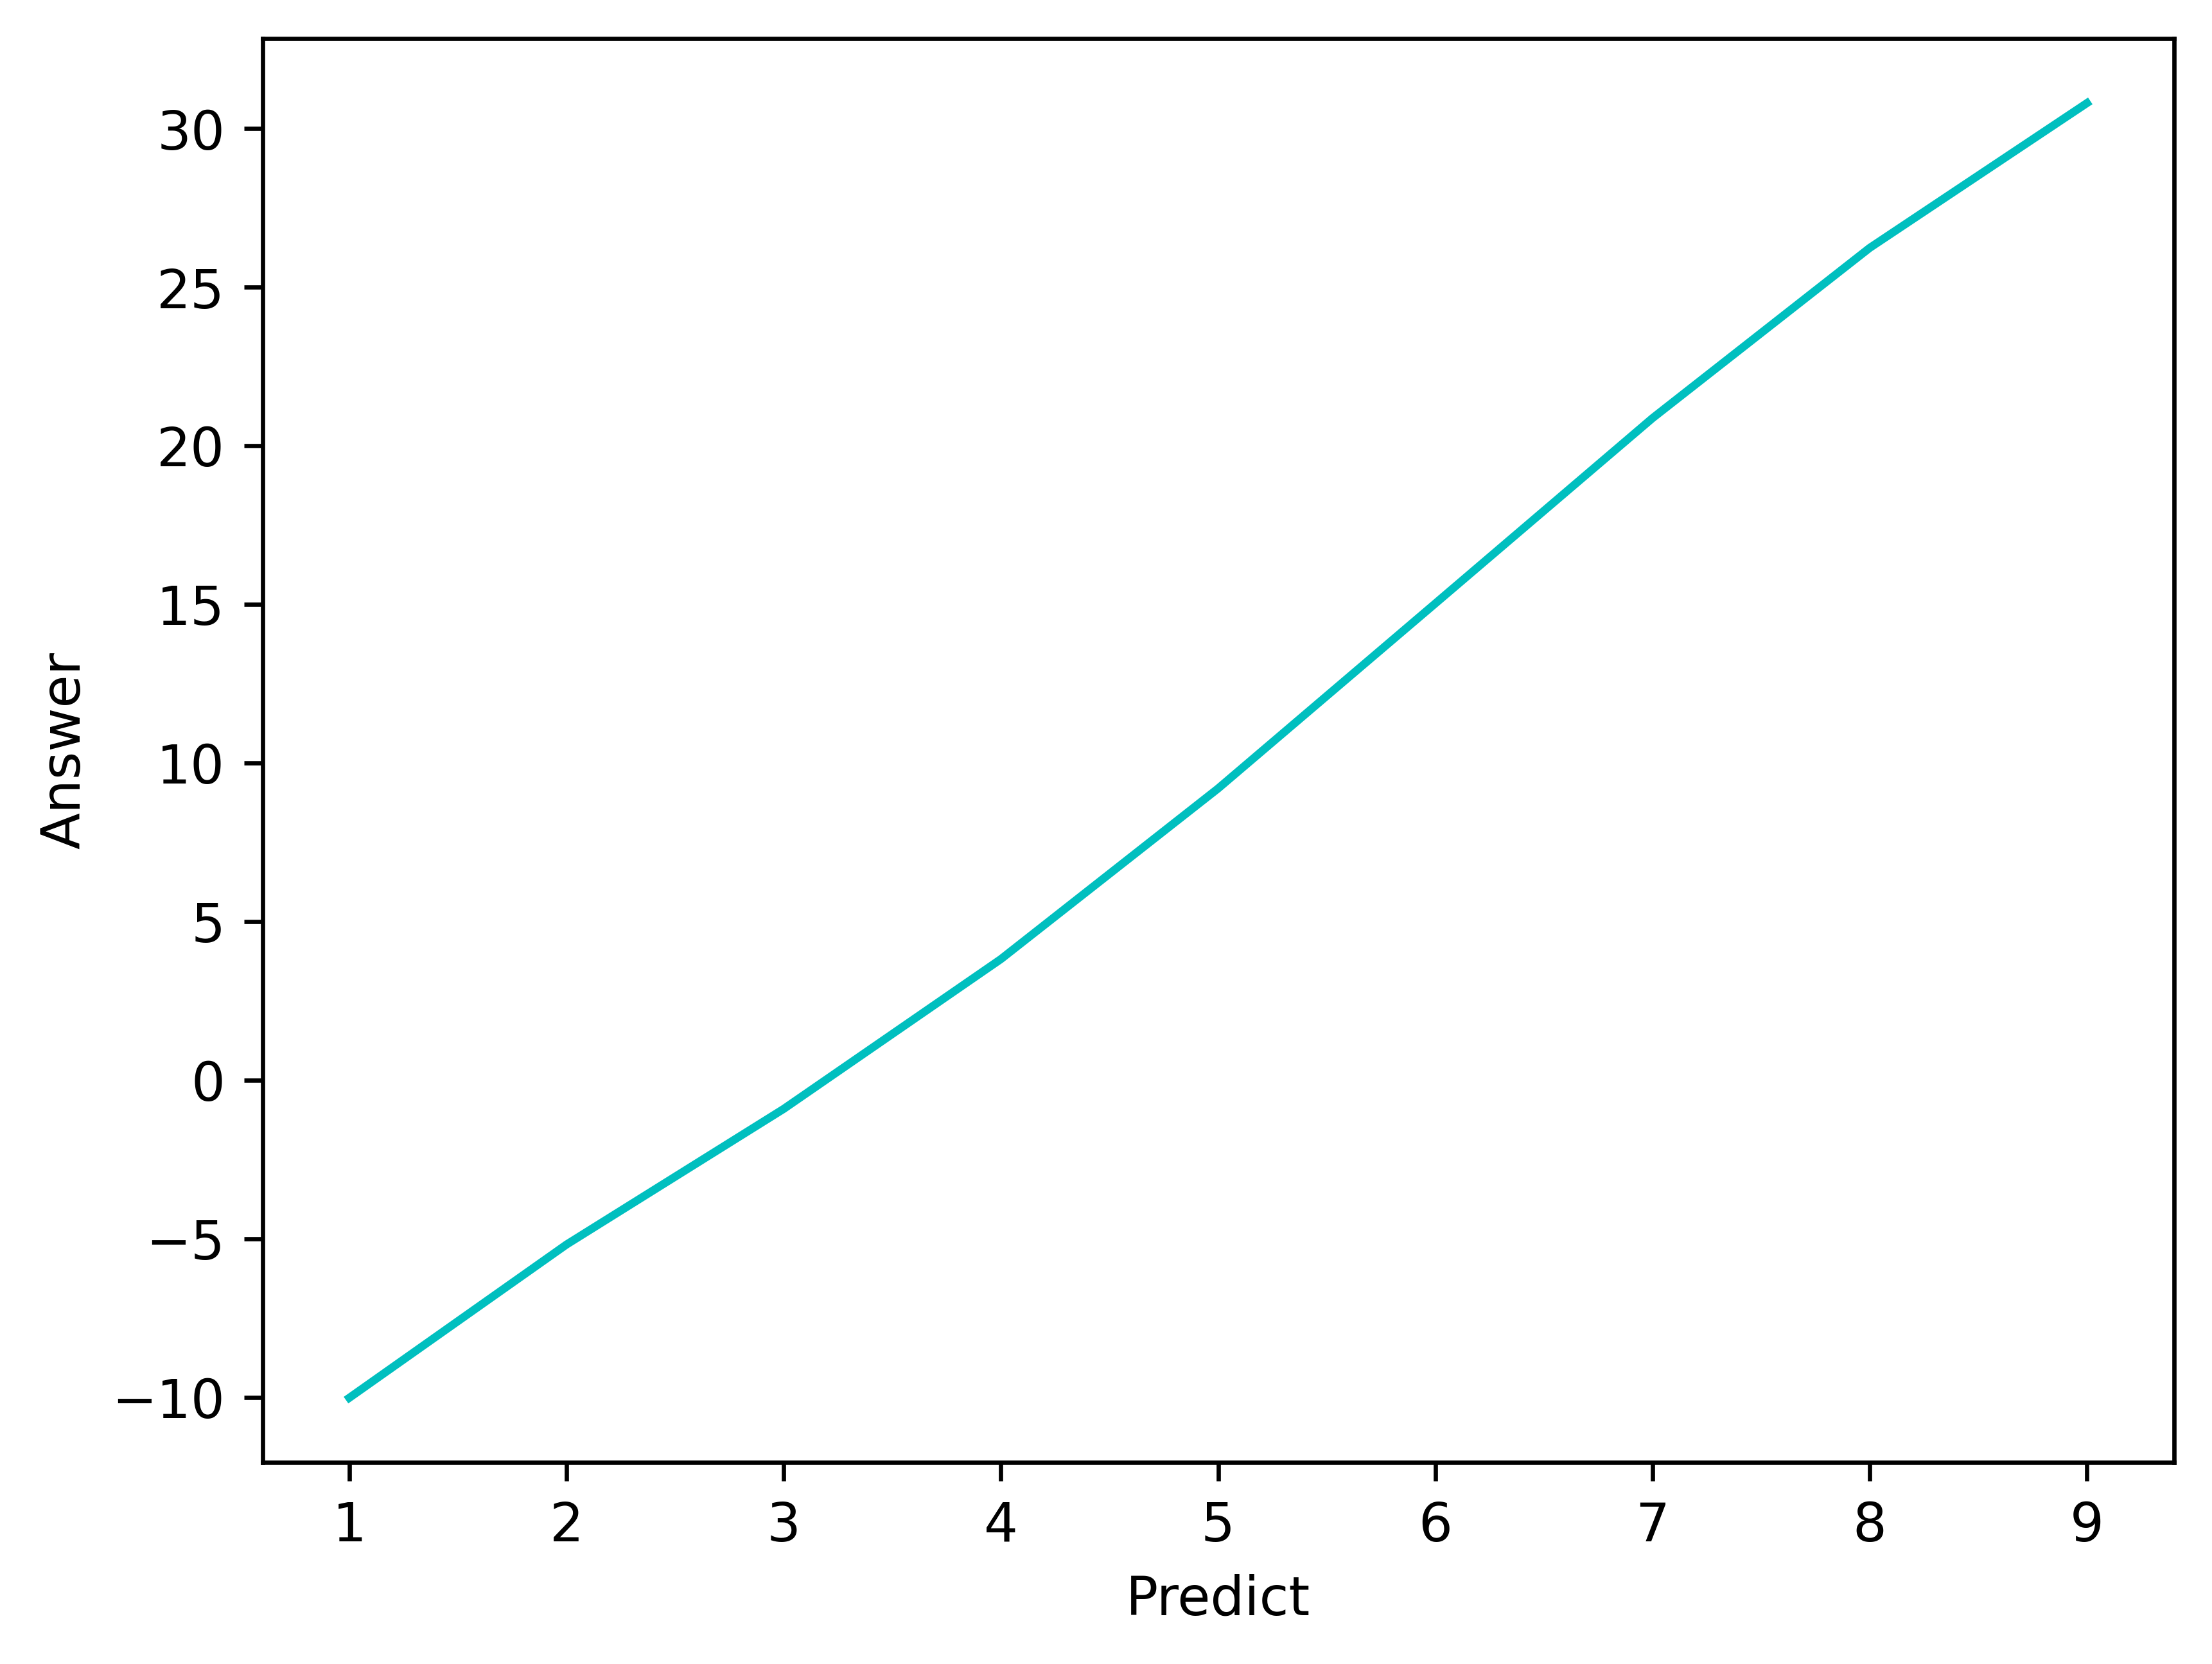

In [58]:
from matplotlib import pyplot as plt

t_range = torch.arange(1., 10.).unsqueeze(1) # 회귀선 범위

fig = plt.figure(dpi=600)
plt.xlabel("Predict")
plt.ylabel("Answer")
# plt.plot(torch.arange(data.shape[0]).numpy(), target.numpy(), 'o') # data point
plt.plot(t_range.numpy(), seq_model(t_range).detach().numpy(), 'c-')
# plt.plot(torch.arange(data.shape[0]).numpy(), seq_model(data_normalized).detach().numpy(), 'kx')

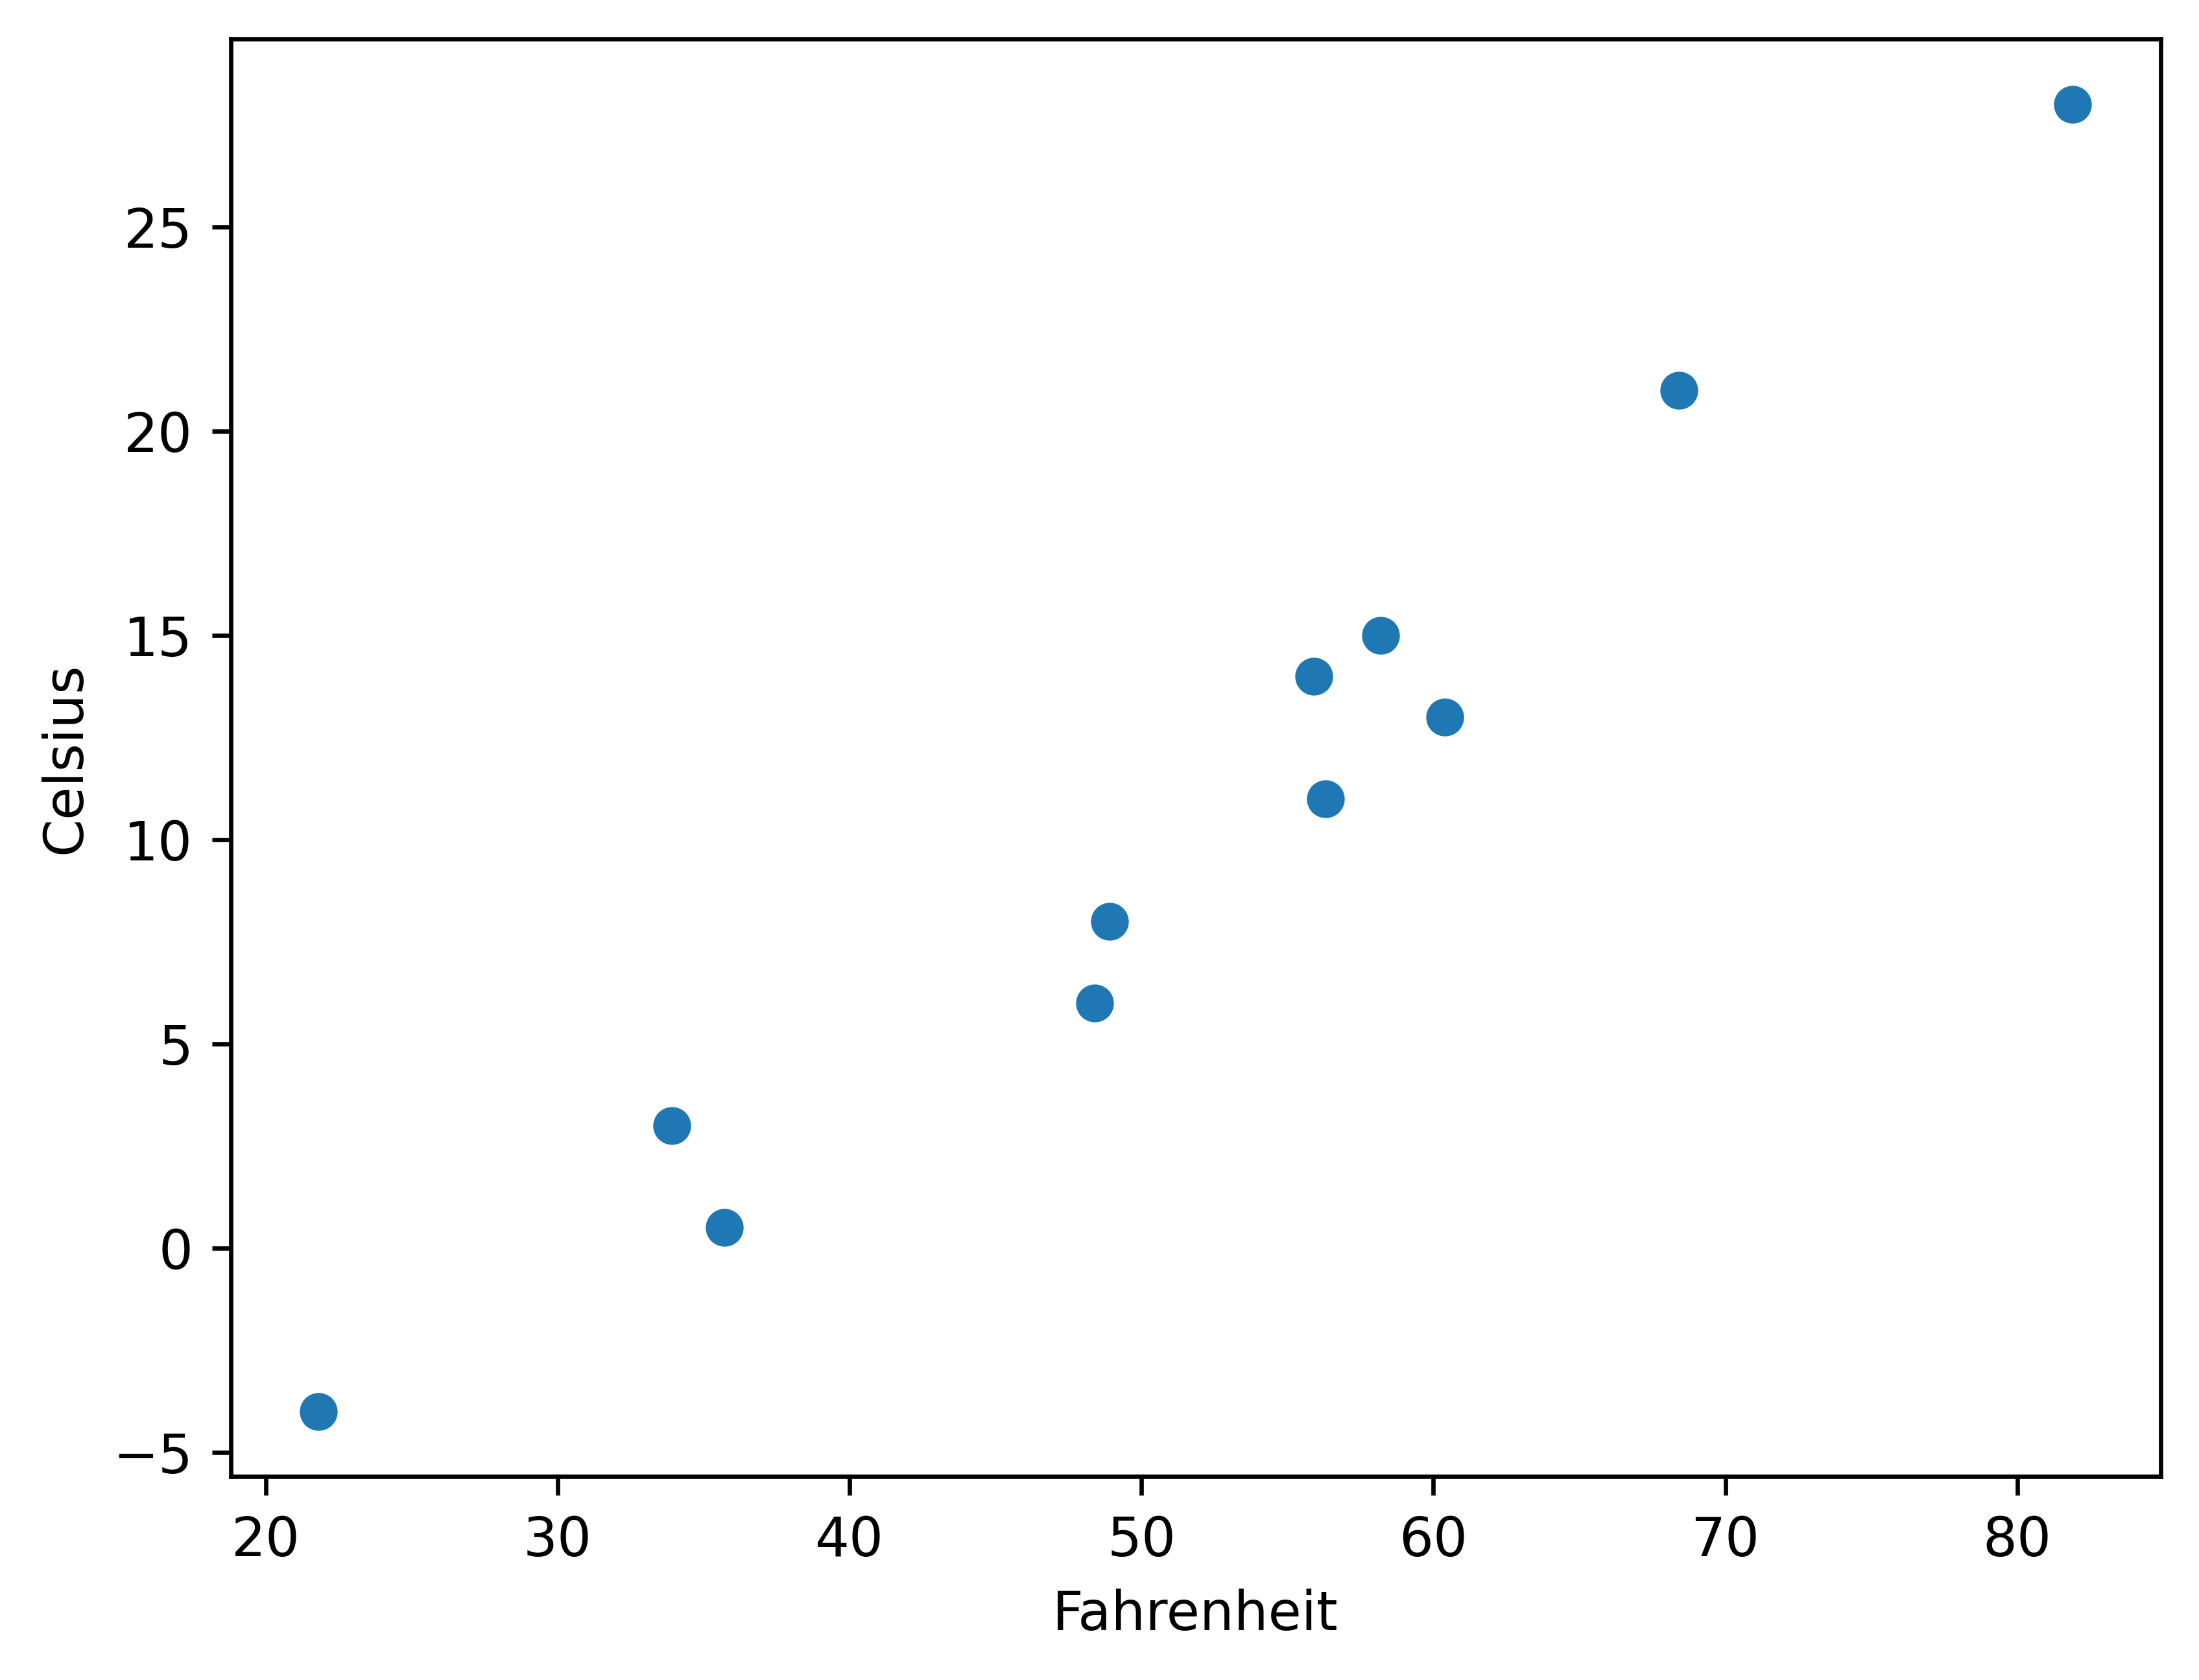

In [43]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
# plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')